In [1]:
import numpy as np
import pandas as pd
import scipy 
import sklearn as sk
import math
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
data = pd.read_csv('full_4.csv')
data.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Colorectal Cancer,Diabetes-related,Firearm-related,Infant Mortality Rate,Lung Cancer,Prostate Cancer in Males,Stroke (Cerebrovascular Disease),Tuberculosis,Dependency,restaurant_id
0,545745,V J DAY CARE CENTER INC,V J DAY CARE CENTER INC,21702.0,Daycare Above and Under 2 Years,Risk 1 (High),1 E 113TH ST,CHICAGO,IL,60628.0,...,32.0,95.5,37.7,9.6,70.3,57.6,55.6,7.9,40.9,1
1,419319,V J DAY CARE CENTER INC,V J DAY CARE CENTER INC,21702.0,Daycare Above and Under 2 Years,Risk 1 (High),1 E 113TH ST,CHICAGO,IL,60628.0,...,32.0,95.5,37.7,9.6,70.3,57.6,55.6,7.9,40.9,1
2,545746,V J DAY CARE CENTER INC,V J DAY CARE CENTER INC,1800876.0,Daycare Above and Under 2 Years,Risk 1 (High),1 E 113TH ST,CHICAGO,IL,60628.0,...,32.0,95.5,37.7,9.6,70.3,57.6,55.6,7.9,40.9,1
3,419315,V J DAY CARE CENTER INC,V J DAY CARE CENTER INC,1800876.0,Daycare Above and Under 2 Years,Risk 1 (High),1 E 113TH ST,CHICAGO,IL,60628.0,...,32.0,95.5,37.7,9.6,70.3,57.6,55.6,7.9,40.9,1
4,1631640,SUBWAY,SUBWAY,1938179.0,Restaurant,Risk 1 (High),1 E 83RD ST,CHICAGO,IL,60619.0,...,24.1,73.2,37.9,10.9,51.5,47.9,50.3,8.2,40.0,2


# Feature Engineering #

Without going into too much detail about each individual variable we created, we creating a wide variety of potentially relevant variables by extracting information from each restaurants previous inspections. Some noteworthy examples are previous inspection fail rate, number of previous failures, and number of complaints. We also created several potentially relevant interactions based on the features we created. 

In [3]:
#Sort data by restaurant id and then by date
data = data.sort_values(by = ['restaurant_id', 'Inspection Date'])

#Divide data into Canvass inspections and Complaint inspections
canvass_data = data[data['Inspection Type'] == 'Canvass']
comp_data = data[data['Inspection Type'] == 'Complaint']

#Calculate overall fail rate for each type of inpection
#so that we can impute these rates for restaurants with no prvious inspection data
canvass_prior = np.sum(canvass_data['Results'] == 'Fail')/float(len(canvass_data))
comp_prior = np.sum(comp_data['Results'] == 'Fail')/float(len(comp_data))

unique_id = pd.unique(data['restaurant_id'])

comp_fail_rate = []
canvass_fail_rate = []
consec_rate = []

num_prev_canvass_failures = []
num_prev_comp_failures = []
num_prev_canvass_inspections = []
num_prev_comp_inspections = []
num_consec_failures = []

last_inspection_fail = []
last_canvass_fail = []

#For each restaurant 
for i in unique_id:
    
    temp_data = data[data['restaurant_id'] == i]
    temp_data.reset_index(drop = True, inplace = True)
    
    n_canvass_inspec = 0.0
    n_comp_inspec = 0.0
    
    n_canvass_failures = 0.0
    n_comp_failures = 0.0
    n_consec_failures = 0.0
    
    #For each inspection for that restaurant
    for j in range(len(temp_data)):
        
        num_prev_canvass_inspections.append(n_canvass_inspec)
        num_prev_comp_inspections.append(n_comp_inspec)
        
        num_prev_canvass_failures.append(n_canvass_failures)
        num_prev_comp_failures.append(n_comp_failures)
        
        if j == 0:
            canvass_fail_rate.append(canvass_prior)
            comp_fail_rate.append(comp_prior)
            num_consec_failures.append(0.5)
            consec_rate.append(0.1)
            
        else:
            
            if n_canvass_inspec != 0:
                canvass_fail_rate.append(n_canvass_failures / n_canvass_inspec)
                
            else:
                canvass_fail_rate.append(canvass_prior)

            
            if n_comp_inspec != 0:
                comp_fail_rate.append(n_comp_failures / n_comp_inspec)
                
            else:
                comp_fail_rate.append(comp_prior)
            
        if j == 1:
            
            num_consec_failures.append(0.5)
            consec_rate.append(0.1)
            
        if j >= 2:
            
            if (temp_data.loc[j-1, 'Results'] == 'Fail') & (temp_data.loc[j-2, 'Results'] == 'Fail'):
                n_consec_failures = n_consec_failures + 1
                num_consec_failures.append(n_consec_failures) 
                consec_rate.append(n_consec_failures / (n_canvass_inspec + n_comp_inspec - 1))
                
            else:
                num_consec_failures.append(n_consec_failures) 
                consec_rate.append(n_consec_failures / (n_canvass_inspec + n_comp_inspec - 1))
        
        
        if (len(temp_data) > 1):
        
            if (j == len(temp_data) - 1) & (temp_data.loc[len(temp_data) - 2, 'Results'] == 'Fail'):
                last_inspection_fail.append(1)
        
            else:
                last_inspection_fail.append(0)
                
        else:
            last_inspection_fail.append(0)
            
        if temp_data.loc[j, 'Inspection Type'] == 'Canvass':       
            n_canvass_inspec = n_canvass_inspec + 1
            
            if temp_data.loc[j, 'Results'] == 'Fail':
                n_canvass_failures = n_canvass_failures + 1
                            
        if temp_data.loc[j, 'Inspection Type'] == 'Complaint':       
            n_comp_inspec = n_comp_inspec + 1
            
            if temp_data.loc[j, 'Results'] == 'Fail':
                n_comp_failures = n_comp_failures + 1       
        
            
print 'done!'

data['canvass fail rate'] = canvass_fail_rate
data['complaint fail rate'] = comp_fail_rate

data['num prev canvass inspections'] = num_prev_canvass_inspections
data['num prev complaint inspections'] = num_prev_comp_inspections
data['num canvass failures'] = num_prev_canvass_failures
data['num complaint failures'] = num_prev_comp_failures
data['last inspection fail'] = last_inspection_fail
data['num consec failures'] = num_consec_failures
data['consec rate'] = consec_rate

total_failures = np.array(num_prev_canvass_failures) + np.array(num_prev_comp_failures)
total_inspections = np.array(num_prev_canvass_inspections) + np.array(num_prev_comp_inspections)

#Create potentially usefull interaction variables
data['complaint-canvass-rate interaction'] = np.array(comp_fail_rate) * np.array(canvass_fail_rate)
data['complaint-canvass-fail interaction'] = np.array(num_prev_canvass_failures) * np.array(num_prev_comp_failures)
data['inspection-canvass-rate interaction'] = total_inspections * np.array(canvass_fail_rate)
data['inspection-complaint-rate interaction'] = total_inspections * np.array(comp_fail_rate)
data['inspection-complaint interaction'] = total_inspections * np.array(num_prev_comp_inspections)
data['inspection-fail interaction'] = total_inspections * total_failures
data['consec-last interaction'] = np.array(num_consec_failures) * np.array(last_inspection_fail)
data['consec-fail interaction'] = np.array(num_consec_failures) * np.array(canvass_fail_rate)

done!


In [11]:
#Looks good!
data.iloc[:, 48:].tail()

,restaurant_id,canvass fail rate,complaint fail rate,num prev canvass inspections,num prev complaint inspections,num canvass failures,num complaint failures,last inspection fail,num consec failures,consec rate,complaint-canvass-rate interaction,complaint-canvass-fail interaction,inspection-canvass-rate interaction,inspection-complaint-rate interaction,inspection-complaint interaction,inspection-fail interaction,consec-last interaction,consec-fail interaction
67898,17508,0.500000,0.337702,4.0,0.0,2.0,0.0,0,1.0,0.333333,0.168851,0.0,2.000000,1.350806,0.0,8.0,0.0,0.500000
67897,17508,0.500000,1.000000,4.0,1.0,2.0,1.0,0,1.0,0.250000,0.500000,2.0,2.500000,5.000000,5.0,15.0,0.0,0.500000
67896,17508,0.400000,1.000000,5.0,1.0,2.0,1.0,0,1.0,0.200000,0.400000,2.0,2.400000,6.000000,6.0,18.0,0.0,0.400000
67895,17508,0.400000,0.500000,5.0,2.0,2.0,1.0,0,1.0,0.166667,0.200000,2.0,2.800000,3.500000,14.0,21.0,0.0,0.400000
67894,17508,0.333333,0.500000,6.0,2.0,2.0,1.0,0,1.0,0.142857,0.166667,2.0,2.666667,4.000000,16.0,24.0,0.0,0.333333


In [12]:
data = data.sort_values(by = ['restaurant_id', 'Inspection Date'])

#Combine all of the various Daycare facility types into one type called 'Daycare'
data['Facility Type'][(data['Facility Type'] == 'Daycare (2 - 6 Years)') | 
                     (data['Facility Type'] == 'Daycare Above and Under 2 Years') |
                     (data['Facility Type'] == 'Daycare Combo 1586')|
                     (data['Facility Type'] == 'Daycare (Under 2 Years)') |
                     (data['Facility Type'] == 'Daycare (2 Years)')|
                     (data['Facility Type'] == 'DAYCARE')] = 'Daycare'

C:\Users\Keyan\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
data.reset_index(drop = True, inplace = True)

#Combine all facility types with less than 100 observations as 'Other'
print 'Before \n', data['Facility Type'].value_counts()[:30]

names = data['Facility Type'].value_counts()[12:].index 

data_other = data[data['Facility Type'].isin(names)]
data.loc[data_other.index, 'Facility Type'] = 'Other'
print '\nAfter \n', data['Facility Type'].value_counts()

Before 
Restaurant                      47635
Grocery Store                    7754
School                           6363
Daycare                          1346
Bakery                           1043
Long Term Care                    476
Catering                          383
Children's Services Facility      347
Golden Diner                      277
Hospital                          237
Wholesale                         143
Liquor                            143
KIOSK                              87
Special Event                      68
Shelter                            58
TAVERN                             50
BANQUET HALL                       45
GAS STATION                        37
Mobile Food Preparer               33
GROCERY/RESTAURANT                 27
Shared Kitchen                     25
BANQUET                            20
STADIUM                            19
PRIVATE SCHOOL                     18
LIVE POULTRY                       17
CHURCH                             17
CAFE

In [427]:
data = data.sort_values(by = ['restaurant_id', 'Inspection Date'])
data.reset_index(drop = True, inplace = True)

#Write csv to file so that other group members can use it
data.to_csv('final_data.csv', index = False)

# Data Visualizations #

In [429]:
## Calculate Pass Rate by Facility Type

#Load Census Data
census_chi = pd.read_csv('Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv')
census_chi.columns = ['Community Area', 'COMMUNITY AREA NAME',
       'PERCENT OF HOUSING CROWDED', 'PERCENT HOUSEHOLDS BELOW POVERTY', 'PERCENT AGED 16+ UNEMPLOYED',
       'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA', 'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ','HARDSHIP INDEX']

for i in range(len(census_chi) - 1):
    census_chi.iloc[i, 0] = str(int(census_chi.iloc[i, 0]))

data2 = census_chi.drop(77)

data['Results'][data['Results'] == 'Pass'] = 1
data['Results'][data['Results'] == 'Fail'] = 0

aggregations = {
    'Results': { # work on the "results" column
        'num_pass': 'sum',  # get the sum
        'total_count': 'count' # get count
    }}
 
agg_by_facility = data.groupby('Facility Type').agg(aggregations)

pd.DataFrame(agg_by_facility).reset_index()

agg_by_facility['pass_prob'] = agg_by_facility['Results']['num_pass'] / agg_by_facility['Results']['total_count']

fac = agg_by_facility['pass_prob'].sort_values(ascending = False)
fac

Facility Type
Children's Services Facility    0.858790
Daycare                         0.834324
Hospital                        0.827004
Catering                        0.801567
Golden Diner                    0.801444
School                          0.799937
Restaurant                      0.778272
Long Term Care                  0.766807
Other                           0.762712
Bakery                          0.736337
Grocery Store                   0.714857
Wholesale                       0.636364
Liquor                          0.468531
Name: pass_prob, dtype: float64

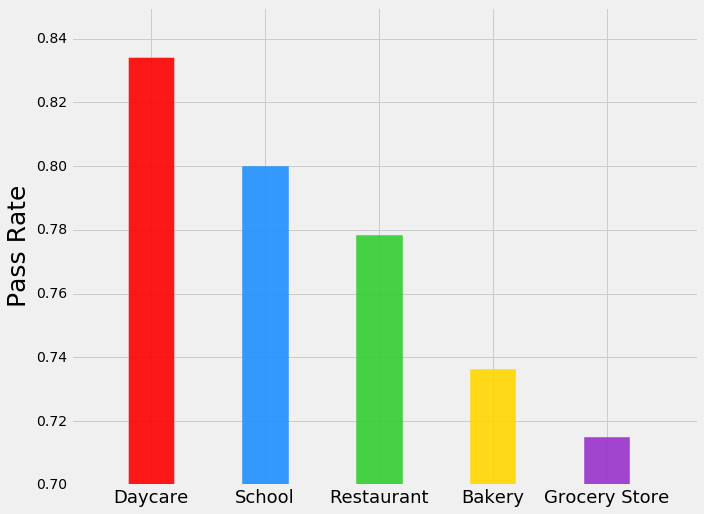

In [434]:
#Pass Rate by Facility Type Bar Graph

fac_bar = fac[[1, 5, 6, 9, 10]] #Only include the most prominent facility types

matplotlib.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(10, 8))
bar = ax.bar(range(5), fac_bar, width=.4, color='red', alpha=.9)
bar[1].set_color('dodgerblue')
bar[2].set_color('limegreen')
bar[3].set_color('gold')
bar[4].set_color('darkorchid')

ax.set_xlim(-.5, 5)
ax.set_ylim(0.7, .85)
ax.set_xticks([.2, 1.2, 2.2, 3.2, 4.2])

ax.set_xticklabels(fac_bar.index, fontsize=18)
#ax.set_title('Pass Rate by Facility Type')
ax.set_ylabel('Pass Rate', fontsize=25)

plt.show()

In [435]:
## Calculate pass rate by community area

aggregations = {
    'Results': { # work on the "results" column
        'num_pass': 'sum',  # get the sum
        'total_count': 'count' # get count
    }}
 
agg_by_community = data.groupby('Community Area').agg(aggregations)

pd.DataFrame(agg_by_community).reset_index()

agg_by_community['pass_prob'] = agg_by_community['Results']['num_pass'] / agg_by_community['Results']['total_count']

data2.index = data2.index + 1

data3 = pd.concat([data2, agg_by_community['pass_prob']], axis=1)
data3.reset_index(drop=True, inplace=True)

In [437]:
data3.iloc[20:,:]

,Community Area,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,pass_prob
20,21,Avondale,6.0,15.3,9.2,24.7,31.0,20039,42.0,0.820126
21,22,Logan Square,3.2,16.8,8.2,14.8,26.2,31908,23.0,0.775375
22,23,Humboldt park,14.8,33.9,17.3,35.4,38.0,13781,85.0,0.704774
23,24,West Town,2.3,14.7,6.6,12.9,21.7,43198,10.0,0.738234
24,25,Austin,6.3,28.6,22.6,24.4,37.9,15957,73.0,0.701105
25,26,West Garfield Park,9.4,41.7,25.8,24.5,43.6,10934,92.0,0.635179
26,27,East Garfield Park,8.2,42.4,19.6,21.3,43.2,12961,83.0,0.691617
27,28,Near West Side,3.8,20.6,10.7,9.6,22.2,44689,15.0,0.797301
28,29,North Lawndale,7.4,43.1,21.2,27.6,42.7,12034,87.0,0.701131
29,30,South Lawndale,15.2,30.7,15.8,54.8,33.8,10402,96.0,0.757642


-0.586765808331


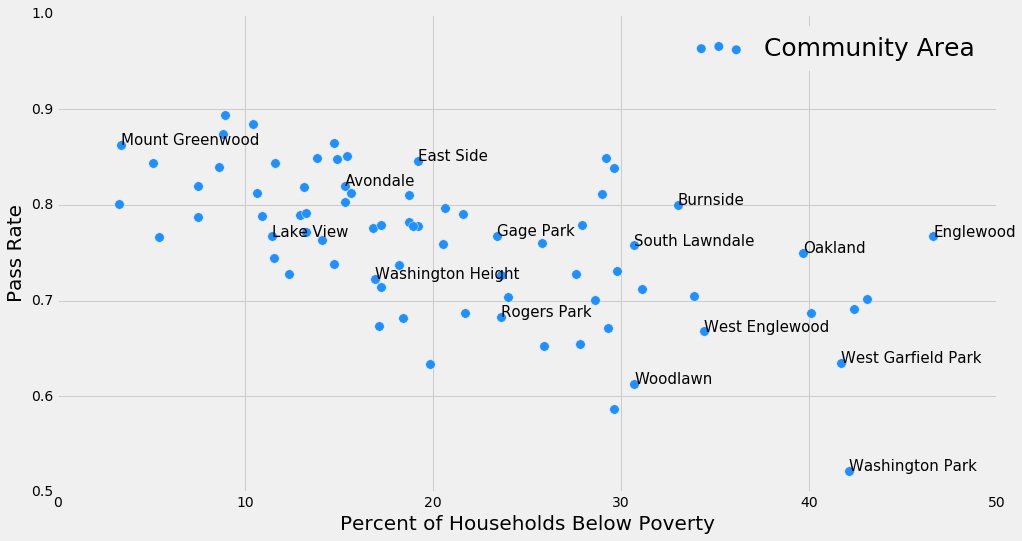

In [440]:
#Scatterplot of Pass Rate vs. Percent of Households Below Poverty

fig, ax1 = plt.subplots(figsize=(15, 8))

x = data4.iloc[:, 3]
y = data4.iloc[:, 9]

r = np.corrcoef(x, y)
print r[0][1] #correlation

ax1.scatter(x, y, s=90, c='dodgerblue', alpha = 1)

ax1.set_xlabel('Percent of Households Below Poverty', fontsize=20)
ax1.set_ylabel('Pass Rate', fontsize=20)
#ax1.set_title('Pass Rate vs. Percent of Households Below Poverty', fontsize=25)
ax1.set_ylim(.5, 1)
plt.legend(loc = 'upper right', labels = ['Community Area'], prop={'size':25})

#Label some community areas by name
for i, txt in enumerate(data4['COMMUNITY AREA NAME']):
    
    if ((i % 5 == 0) or (i in [29, 38, 64, 71])) and (i not in [10, 15, 30, 55]):
        ax1.annotate(txt, (x[i],y[i]), fontsize = 15)
    else:
        continue

plt.show()

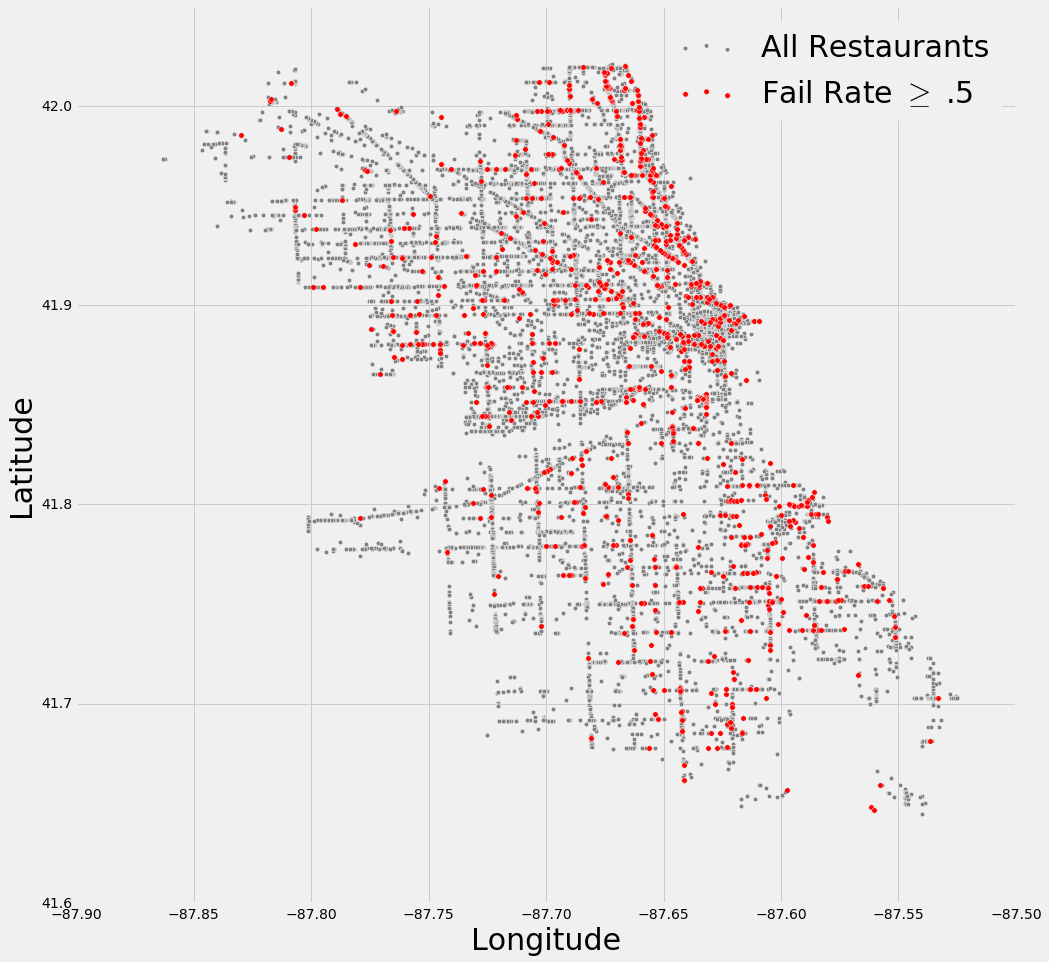

In [417]:
#Location of Restaurants with High Fail Rates Scatterplot

data = pd.read_csv('canvass_full_correct_fail_rates.csv')
fail_long = data['Longitude'][(data['Results'] == 'Fail') & (data['fail rate'] >= .5)]
fail_lat = data['Latitude'][(data['Results'] == 'Fail') & (data['fail rate'] >= .5)]
pass_long = data['Longitude'][data['Results'] == 'Pass']
pass_lat = data['Latitude'][data['Results'] == 'Pass']

lon = data['Longitude']
lat = data['Latitude']

matplotlib.style.use('fivethirtyeight')

fig, ax1 = plt.subplots(figsize=(15, 15))

ax1.scatter(lon, lat, s=20, c='grey', alpha = 1)
ax1.scatter(fail_long, fail_lat, s=30, c='red', alpha = 1)

ax1.set_xlim(-87.9, -87.5)
ax1.set_ylim(41.6, 42.05)
ax1.set_xlabel('Longitude', fontsize=30)
ax1.set_ylabel('Latitude', fontsize=30)
#ax1.set_title('Location of Restaurants with High Fail Rates', fontsize=25)
plt.legend(loc = 'upper right', labels = ['All Restaurants', 'Fail Rate $\geq$ .5'], prop={'size':30})

plt.show()

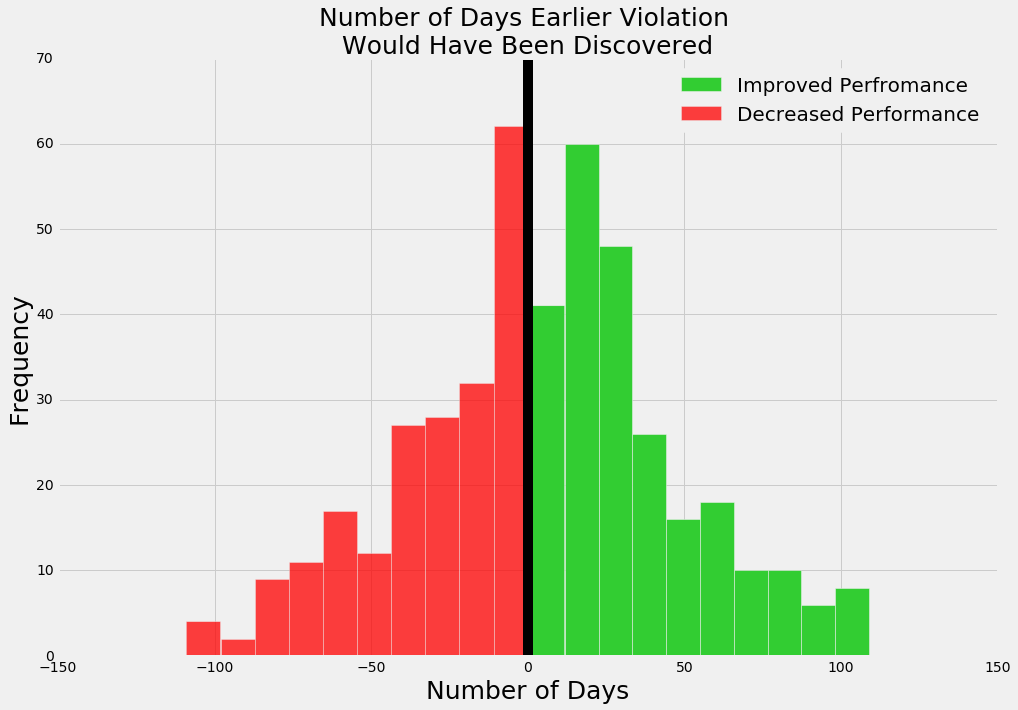

In [53]:
#Baseline Model Histogram of Days Earlier Violation Would Have Been Discovered

data6 = pd.read_csv('days_improve_4.csv')
data6 = data6.iloc[:, 1]

pos = data6[data6 >= 0].values
neg = data6[data6 < 0].values

matplotlib.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(15, 10))
ax1.hist(pos, 10, facecolor='limegreen', alpha=1, label="Improved Perfromance")
ax1.hist(neg, 10, facecolor='red', alpha=.75, label="Decreased Performance")
ax1.legend(prop={'size':20})
ax1.set_title('Number of Days Earlier Violation \nWould Have Been Discovered', fontsize=25)
ax1.set_xlabel('Number of Days', fontsize=25)
ax1.set_ylabel('Frequency',  fontsize=25)

ax1.axvline(0, linewidth=10, color = 'black')

plt.show()

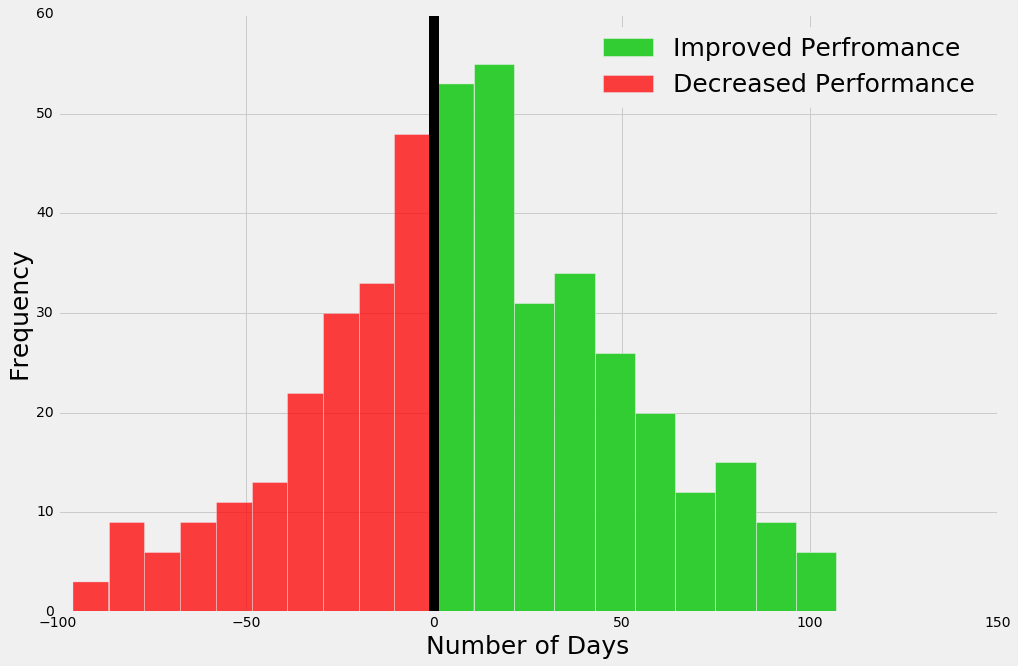

In [450]:
#Random Forest Model Histogram of Days Earlier Violation Would Have Been Discovered

data7 = pd.read_csv('days_improve 2.csv')
data7.columns = ['v1']
pos = data7[data7['v1'] >= 0].values
neg = data7[(data7['v1'] < 0)].values

matplotlib.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(15, 10))
ax1.hist(pos, 10, facecolor='limegreen', alpha=1, label="Improved Perfromance")
ax1.hist(neg, 10, facecolor='red', alpha=.75, label="Decreased Performance")
ax1.legend(prop={'size':25})
#x1.set_title('Number of Days Earlier Violation \nWould Have Been Discovered', fontsize=25)
ax1.set_xlabel('Number of Days', fontsize=25)
ax1.set_ylabel('Frequency',  fontsize=25)

ax1.axvline(0, linewidth=10, color = 'black')

plt.show()

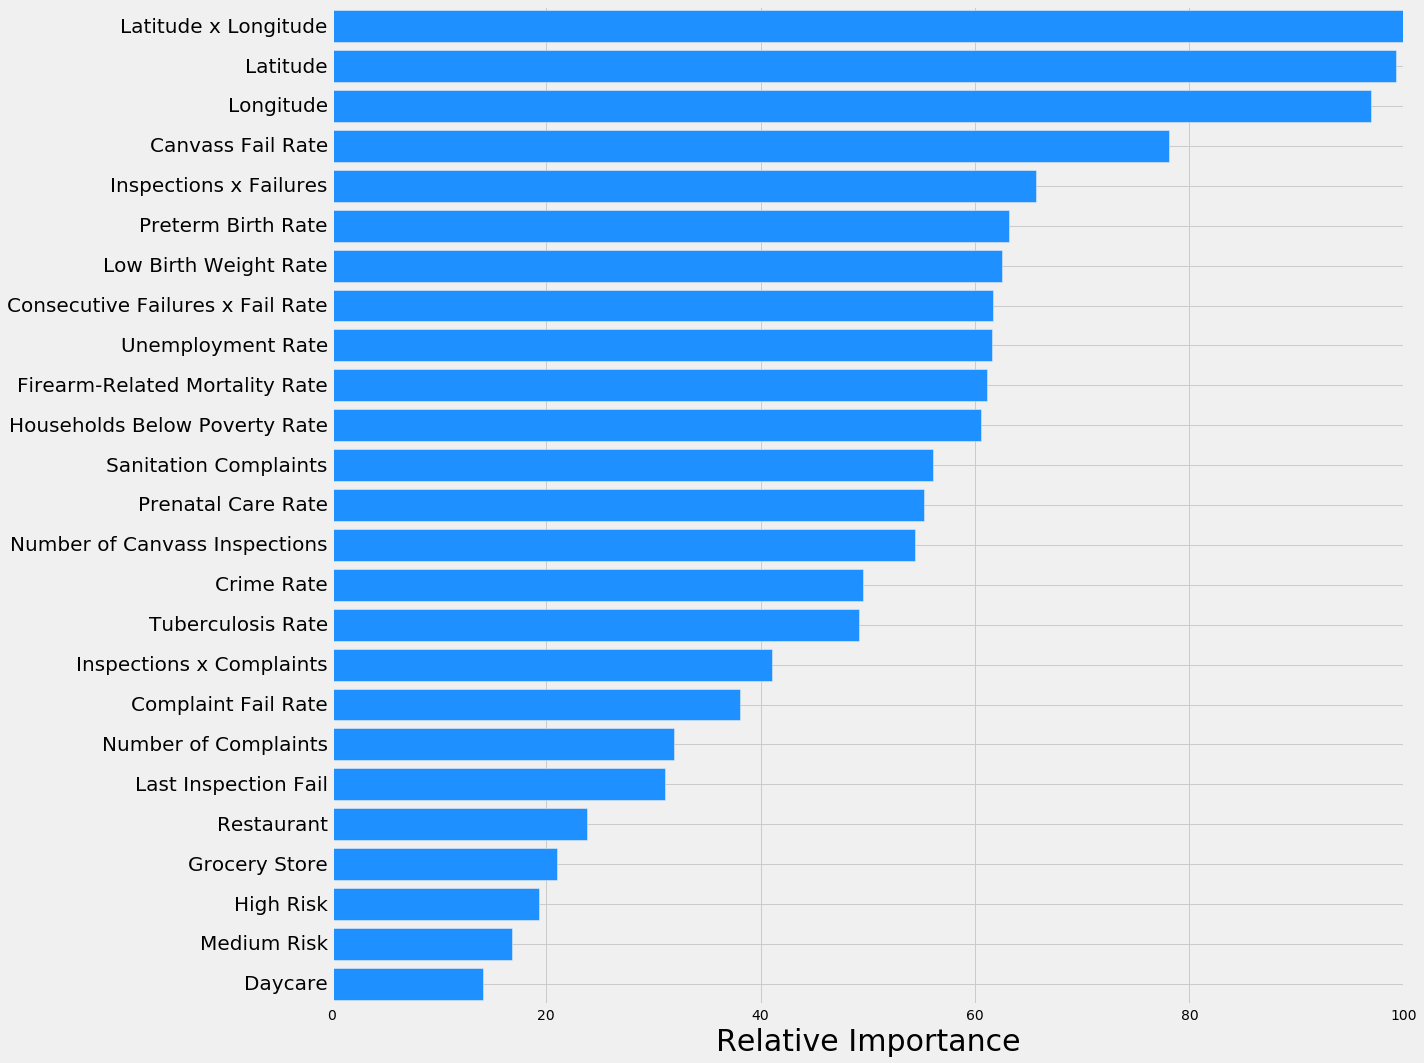

In [444]:
#Variable importance plot from random forest model

data8 = pd.read_csv('vi.csv')
importance = data8['Importance'].values
names = data8['Variable'].values

# make importances relative to max importance
importance = 100.0 * (importance / importance.max())
sorted_index = np.argsort(importance)
pos = np.arange(sorted_index.shape[0]) + .5

plt.figure(figsize=(20, 15))
plt.barh(pos, importance[sorted_index], align='center', color = 'dodgerblue')
plt.yticks(pos, names[sorted_index], fontsize=20)
plt.xlabel('Relative Importance', fontsize=30)
#plt.title('Variable Importance', fontsize=30)
plt.tight_layout()
plt.show()



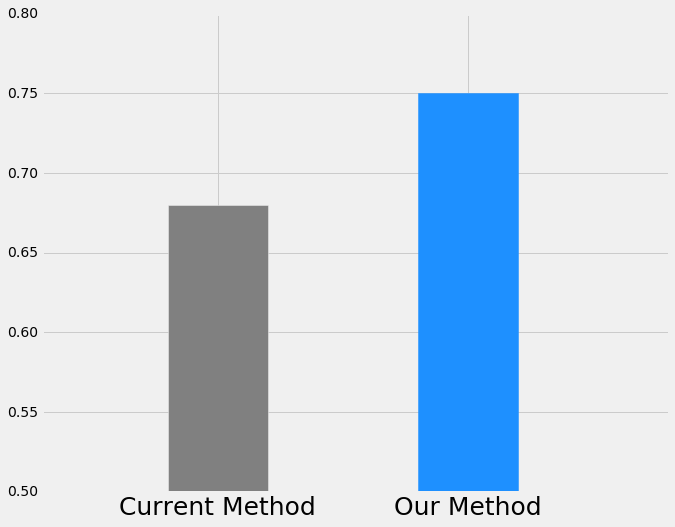

In [445]:
# Proportion of Failures Found in First Half of Test Period Bar Graph

prop = [.68, .75]

fig, ax = plt.subplots(figsize=(10, 8))
bar = ax.bar([1,2], prop, width=.4, color='grey', alpha= 1)
bar[1].set_color('dodgerblue')
ax.set_xlim(.5, 3)
ax.set_ylim(.5, .8)
ax.set_xticks([1.2, 2.2])
ax.set_xticklabels(['Current Method', 'Our Method'], fontsize=25)
#ax.set_title('Proportion of Failures Found in First Half of Test Period')
plt.show()